In [1]:
import matplotlib.pyplot as plt
from seaborn import heatmap
from seaborn import pairplot
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP
from besos.parameters import RangeParameter, FieldSelector, FilterSelector, Parameter, expand_plist, wwr, CategoryParameter, GenericSelector
from besos.problem import EPProblem
import pandas as pd
import numpy as np

In [2]:
output_dir = './opt_out'
epw_file = '../weather/Torre_Pellice-hour.epw'
# Define the list of idf files with different glazing type setting and set each type to a int flag
idf_files = ['../IDF/single_f.idf','../IDF/double_f.idf','../IDF/triple_f.idf']
idf_flags = [1,2,3]

In [3]:
# Load idf files defined in the list
buildings = []
for file in idf_files:
    buildings.append(ef.get_building(file))

In [4]:
# [materials.Name for materials in building.idfobjects['WindowShadingControl']]# get a list of the Name property of all IDF objects of class MATERIAL
# for materials in building.idfobjects["WindowShadingControl"]:
#     if materials.Name =='1001-MainXground:Zone1':
#         print(materials)

In [5]:
# Define the fields to optimaize
insulation = FieldSelector(class_name='Material',\
                           object_name='XPS Extruded Polystyrene  - CO2 Blowing_.0795',\
                           field_name='Thickness')
ach = FieldSelector(class_name='ZoneVentilation:DesignFlowRate',\
                            object_name='*',\
                            field_name='Air Changes per Hour')
shading_temp = FieldSelector(class_name='WindowShadingControl',\
                                object_name='*',\
                                field_name='Setpoint')
shading_irradiation = FieldSelector(class_name='WindowShadingControl',\
                                object_name='*',\
                                field_name='Setpoint 2')

In [6]:
#Define the values for each field
insulation_options=[0.25,0.3,0.35]
ach_options = [0,2,4,6]
shading_temp_options = [20,24,28]
shading_irradiation_options=[80,120,240,300]
# insulation_options=[0.35]
# ach_options = [6]
# shading_temp_options = [20,24,28]
# shading_irradiation_options=[80,120,240,300]

insulation_range = CategoryParameter(options=insulation_options)
ach_choice = CategoryParameter(options=ach_options)
shading_temp_range=CategoryParameter(options=shading_temp_options)
shading_irradiation_range=CategoryParameter(options=shading_irradiation_options)


In [7]:
# Define the params according to fields and field valuse
insulation_param = Parameter(selector=insulation,
                            value_descriptors=[insulation_range],
                            name='Insulation Thickness')
ach_param = Parameter(selector=ach,
                            value_descriptors=[ach_choice],
                            name='ACH')
shading_temp_param = Parameter(selector=shading_temp,
                            value_descriptors=[shading_temp_range],
                            name='shading temperature')
shading_irradiation_param =Parameter(selector=shading_irradiation,
                            value_descriptors=[shading_irradiation_range],
                            name='shading irradiation')

parameters = [insulation_param,ach_param,shading_temp_param,shading_irradiation_param] 

In [8]:
# Define the objectives and the problem
objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility'] # these get made into `MeterReader` or `VariableReader`
problem=EPProblem(parameters, objectives) # problem = parameters + objectives
problem

EPProblem(inputs=[Parameter(selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='XPS Extruded Polystyrene  - CO2 Blowing_.0795'), value_descriptors=[CategoryParameter(options=[0.35])]), Parameter(selector=FieldSelector(field_name='Air Changes per Hour', class_name='ZoneVentilation:DesignFlowRate', object_name='*'), value_descriptors=[CategoryParameter(options=[6])]), Parameter(selector=FieldSelector(field_name='Setpoint', class_name='WindowShadingControl', object_name='*'), value_descriptors=[CategoryParameter(options=[20, 24, 28])]), Parameter(selector=FieldSelector(field_name='Setpoint 2', class_name='WindowShadingControl', object_name='*'), value_descriptors=[CategoryParameter(options=[80, 120, 240, 300])])], outputs=[MeterReader(class_name='Output:Meter', func=<function sum_values at 0x7f80e8514550>, key_name='Electricity:Facility'), MeterReader(class_name='Output:Meter', func=<function sum_values at 0x7f80e8514550>, key_name='DistrictHeating:Facility'

In [9]:
# Create the samples (each idf with different glazing setting will run accross these samples)
# samples = sampling.dist_sampler(sampling.lhs, problem, num_samples=2)
# samples
samples_raw = []
for i_o in insulation_options:
    for a_o in ach_options:
        for s_t_o in shading_temp_options:
            for s_i_o in shading_irradiation_options:
                samples_raw.append([i_o,a_o,s_t_o,s_i_o])
samples = pd.DataFrame(np.array(samples_raw),columns=['Insulation Thickness','ACH','shading temperature','shading irradiation'])
samples

,Insulation Thickness,ACH,shading temperature,shading irradiation
0,0.35,6.0,20.0,80.0
1,0.35,6.0,20.0,120.0
2,0.35,6.0,20.0,240.0
3,0.35,6.0,20.0,300.0
4,0.35,6.0,24.0,80.0
5,0.35,6.0,24.0,120.0
6,0.35,6.0,24.0,240.0
7,0.35,6.0,24.0,300.0
8,0.35,6.0,28.0,80.0
9,0.35,6.0,28.0,120.0


In [10]:
# Evaluate the probem with different idfs and collect the results
results = []
for i in range(len(buildings)):
    evaluator = EvaluatorEP(problem, buildings[i], out_dir=output_dir, err_dir=output_dir ,epw=epw_file) # evaluator = problem + building
    output = evaluator.df_apply(samples, keep_input=True)
    results.append(output)

Executing:   0%|          | 0/12 [00:00<?, ?row/s]

EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:04
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:05
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:05
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:06
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:06
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:06
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:07
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:07
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:07
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:08
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:08
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:08
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


Executing:   0%|          | 0/12 [00:00<?, ?row/s]

EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:09
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:09
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:10
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:10
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:10
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:11
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:11
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:12
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:12
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Run Time=00hr 00min 16.52sec
EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:12
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:13
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:13
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


Executing:   0%|          | 0/12 [00:00<?, ?row/s]

EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:14
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:14
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:14
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:15
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:15
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:16
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:16
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:16
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:17
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:17
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:18
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.11 01:18
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


In [11]:
dataframes = []
for i in range(len(results)):
    df = results[i]
    df['glazing layers']=idf_flags[i]
    dataframes.append(df)
#     final_result.append(df,ignore_index=True)
merged_result = pd.concat(dataframes,ignore_index=True)
electricity = merged_result["Electricity:Facility"]
electricity = electricity/3.6e6
merged_result["Electricity:Facility"]=electricity
heating = merged_result["DistrictHeating:Facility"]
heating = heating/3.6e6
merged_result["DistrictHeating:Facility"]=heating
cooling = merged_result["DistrictCooling:Facility"]
cooling = cooling/3.6e6
merged_result["DistrictCooling:Facility"]=cooling
merged_result=merged_result.reindex(columns=["Insulation Thickness","ACH","shading temperature","shading irradiation","glazing layers","Electricity:Facility","DistrictHeating:Facility","DistrictCooling:Facility"])

In [12]:
results[0]

,Insulation Thickness,ACH,shading temperature,shading irradiation,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,glazing layers
0,0.35,6.0,20.0,80.0,8.835440e+09,2.722429e+10,3.750128e+09,1
1,0.35,6.0,20.0,120.0,8.779197e+09,2.722319e+10,3.820614e+09,1
2,0.35,6.0,20.0,240.0,8.641403e+09,2.721211e+10,4.212941e+09,1
3,0.35,6.0,20.0,300.0,8.575224e+09,2.720075e+10,4.524185e+09,1
4,0.35,6.0,24.0,80.0,8.550056e+09,2.713856e+10,6.690132e+09,1
5,0.35,6.0,24.0,120.0,8.522700e+09,2.713861e+10,6.722801e+09,1
6,0.35,6.0,24.0,240.0,8.461733e+09,2.713898e+10,6.931026e+09,1
7,0.35,6.0,24.0,300.0,8.434143e+09,2.713887e+10,7.069688e+09,1
8,0.35,6.0,28.0,80.0,8.333084e+09,2.713868e+10,9.133633e+09,1
9,0.35,6.0,28.0,120.0,8.329901e+09,2.713868e+10,9.140380e+09,1


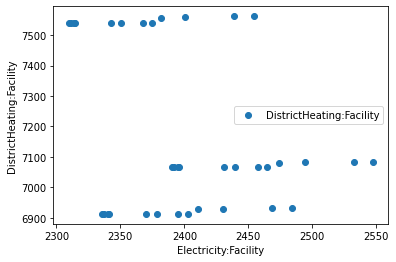

In [13]:
_ = merged_result.plot(x=objectives[0], y=objectives[1], style = 'o')
plt.xlabel(objectives[0])
plt.ylabel(objectives[1])
plt.savefig(output_dir+'/obj_vs.png')

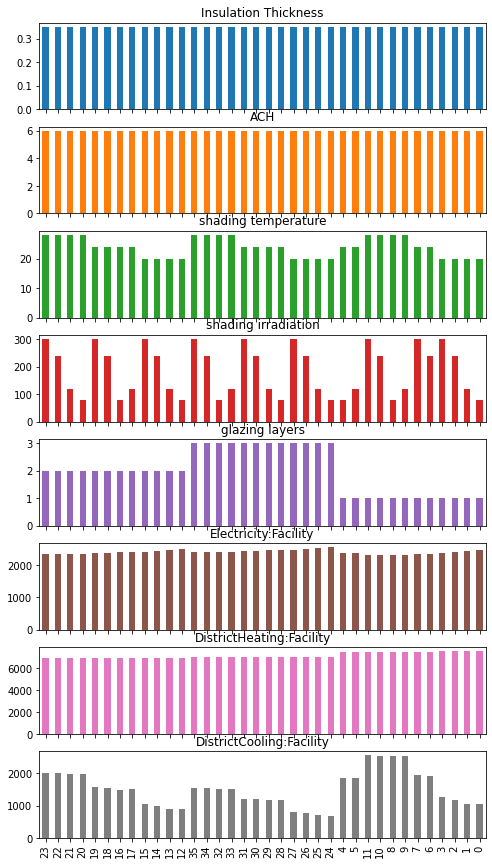

In [14]:
outputs = merged_result.sort_values(by=objectives[1])
ax=outputs.plot.bar(subplots=True,legend=None, figsize=(8,15))
outputs.to_csv(output_dir + '/result' + '.csv', index = False)
plt.savefig(output_dir+'/sort_value.png')

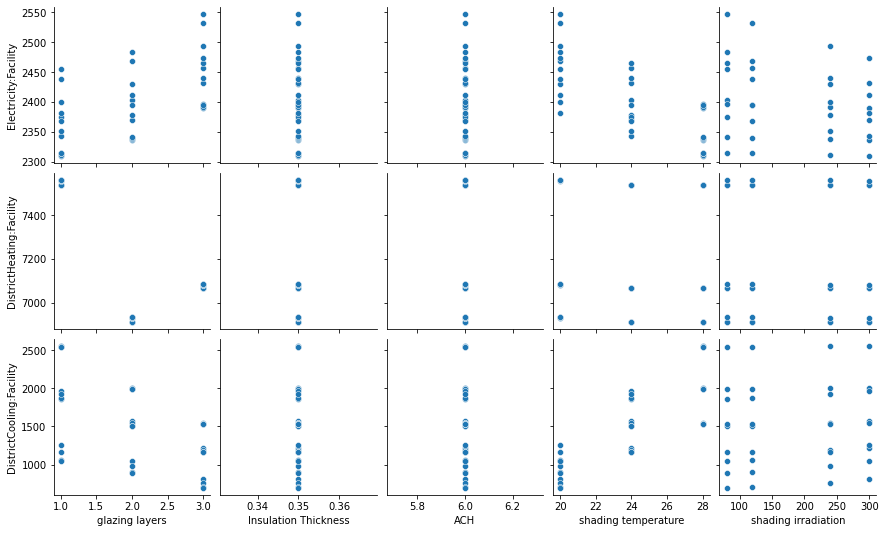

In [15]:
var= list(set(merged_result.columns.tolist())-set(objectives))
_=pairplot(outputs,x_vars=var, y_vars=objectives, kind="scatter")
plt.savefig(output_dir+'/parametric_analysis.png')

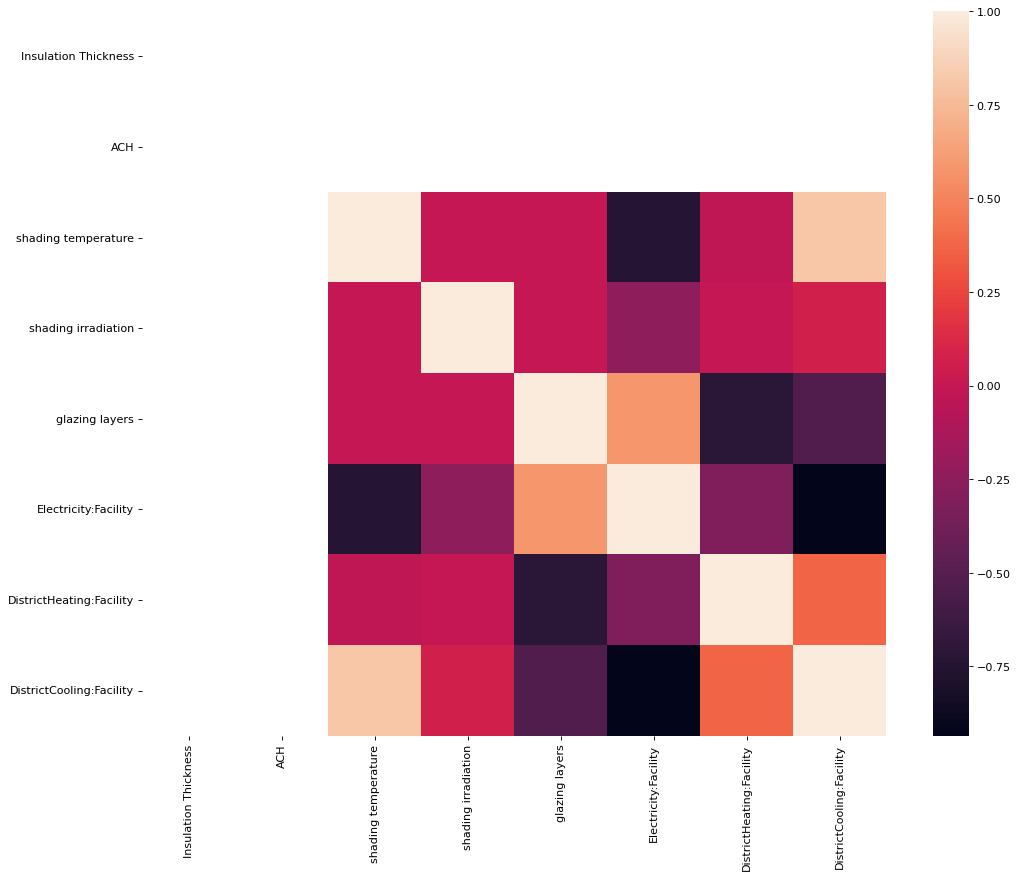

In [16]:
plt.figure(figsize=(15, 12), dpi=80)
_= heatmap(outputs.corr())
plt.savefig(output_dir+'/heatmap_sam.png')